In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import admix
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
UKB_GENO_DIR = "/u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed"
PAGE_GENO_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/imputed/"

In [3]:
# also run the code with "ukb" -> "page"
study = "page"

if study == "ukb":
    geno_dir = UKB_GENO_DIR
else:
    geno_dir = PAGE_GENO_DIR

100%|██████████| 51/51 [01:12<00:00,  1.41s/it]


74 / 118 SNPs left after filtering for MAF


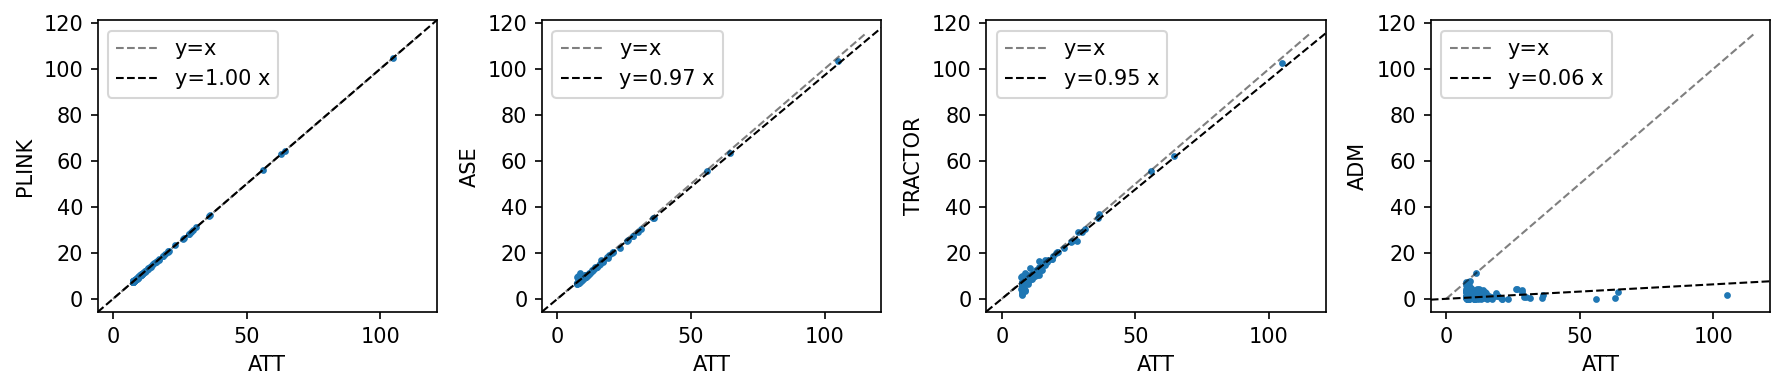

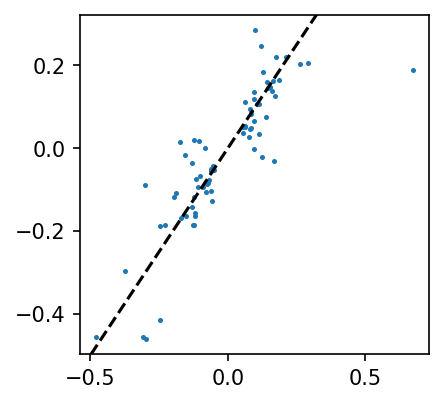

In [6]:
clump_file_list = glob.glob(f"out/gwas/{study}/*.clumped")

method_list = ["HET", "ATT", "ASE", "TRACTOR", "ADM", "PLINK"]
dict_pval = {method: [] for method in method_list}

for clump_file in tqdm(clump_file_list):
    basename = os.path.basename(clump_file)
    trait, chrom = basename.rsplit(".", 2)[0:2]
    prefix = f"out/gwas/{study}/{trait}.{chrom}"
    for method in method_list:
        if method != "PLINK":
            df = pd.read_csv(
                f"{prefix}.{method}.assoc", delim_whitespace=True, index_col=0
            )
        else:
            df = (
                pd.read_csv(f"{prefix}.assoc", delim_whitespace=True)
                .set_index("SNP")
                .loc[df.index, :]
            )
        df.insert(0, "TRAIT", trait)
        dict_pval[method].append(df)
for method in dict_pval:
    dict_pval[method] = pd.concat(dict_pval[method]).reset_index()

fig, axes = plt.subplots(figsize=(12, 2.7), dpi=150, ncols=4)
for i, m2 in enumerate(["PLINK", "ASE", "TRACTOR", "ADM"]):
    admix.plot.compare_pval(
        dict_pval["ATT"].P.values, dict_pval[m2].P.values, ax=axes[i]
    )
    axes[i].set_xlabel("ATT")
    axes[i].set_ylabel(m2)
plt.tight_layout()

df_snp_info = pd.concat(
    [
        pd.read_csv(f"{geno_dir}/chr{chrom}.snp_info", index_col=0, sep="\t")
        for chrom in range(1, 23)
    ]
).rename(columns={"LANC_FREQ1": "EUR_FREQ", "LANC_FREQ2": "AFR_FREQ"})

df_het = dict_pval["HET"].copy()
df_het = df_het.rename(columns={"P": "HET_P"})
df_het[["EUR_FREQ", "AFR_FREQ"]] = (
    df_snp_info[["EUR_FREQ", "AFR_FREQ"]].loc[df_het.snp.values, :].values
)
n_het = len(df_het)
df_het = df_het.loc[
    df_het.EUR_FREQ.between(0.005, 0.995) & df_het.AFR_FREQ.between(0.005, 0.995)
]
print(f"{len(df_het)} / {n_het} SNPs left after filtering for MAF")

for method in ["ATT", "ASE", "TRACTOR", "ADM"]:
    df_merged = dict_pval[method].merge(df_het[["snp", "TRAIT"]])
    assert np.all(df_merged[["snp", "TRAIT"]].values == df_het[["snp", "TRAIT"]].values)
    df_het[f"{method}_P"] = df_merged["P"].values

df_het.to_csv(f"out/summary/{study}_het_info.tsv", sep="\t", index=False)
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_het["G2_BETA"], df_het["G1_BETA"], s=2)
ax.axline((0, 0), slope=1, color="black", ls="--")